In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
#df = pd.read_csv('/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/movementLeftFoot.csv')
#df=(df-df.std())/(df.mean())
path="/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/spiderData/"
if sys.platform.startswith('win'):
    path="C:/Users/dexte/Documents/GitHub/TactileSensor/Code/Data collection/robot/spiderData/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.version.cuda)
print("GPU:",torch.cuda.is_available())

11.7
GPU: True


# Robot foot data interpreter

## sort data

In [9]:
def config_data(name):
    df = pd.read_csv(path+name)

    # Initialize variables
    arrays = []
    current_array = []

    # Iterate through the rows
    for index, row in df.iterrows():
        servo_position = row['servo2']
        p_values = [row[f'p{i+1}'] for i in range(16)]  # Assuming columns p0 to p16

        # Check if servo_position is 10
        if servo_position == 10:
            if current_array:
                arrays.append(current_array)  # Append the completed array
            current_array = []  # Start a new array

        current_array.append(p_values)  # Append p values to the current array

    # Append the last array if not already done
    if current_array:
        arrays.append(current_array)

    return np.array(arrays)


(30, 110, 16)

(110, 16) (110,)
(110, 16) (110,)
(110, 16) (110,)
(110, 16) (110,)


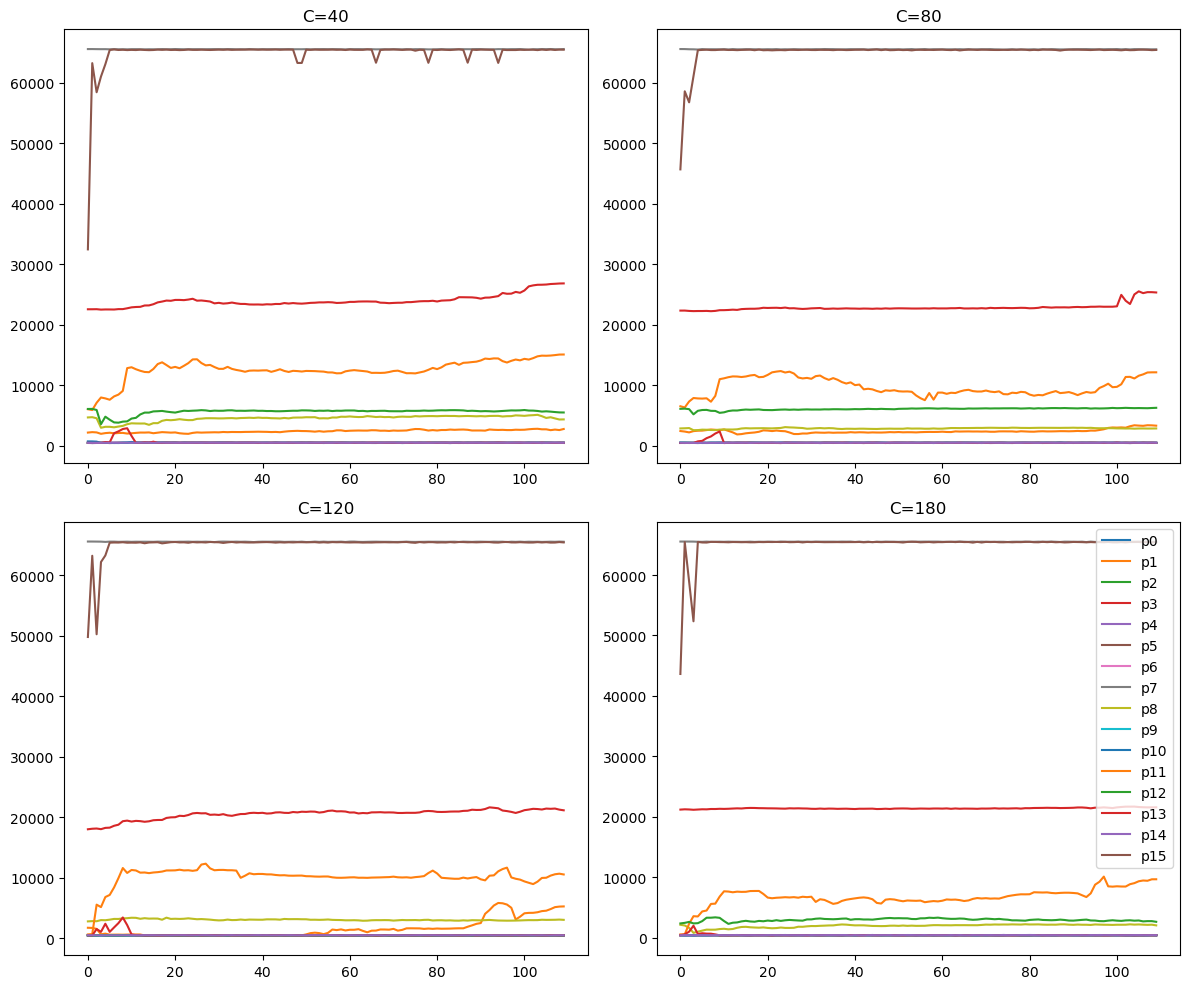

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

d=config_data("sandpaper_C40_1.csv")
averaged = np.average(d,axis=0)
print(averaged.shape,averaged[:,0].shape)
for key in range(len(averaged[0])):
    axs[0][0].plot(averaged[:,key],label="p"+str(key))

axs[0][0].set_title("C=40")

d=config_data("sandpaper_C80_1.csv")
averaged = np.average(d,axis=0)
print(averaged.shape,averaged[:,0].shape)
for key in range(len(averaged[0])):
    axs[0][1].plot(averaged[:,key],label="p"+str(key))

axs[0][1].set_title("C=80")

d=config_data("sandpaper_C120_1.csv")
averaged = np.average(d,axis=0)
print(averaged.shape,averaged[:,0].shape)
for key in range(len(averaged[0])):
    axs[1][0].plot(averaged[:,key],label="p"+str(key))

axs[1][0].set_title("C=120")

d=config_data("sandpaper_C180_1.csv")
averaged = np.average(d,axis=0)
print(averaged.shape,averaged[:,0].shape)
for key in range(len(averaged[0])):
    axs[1][1].plot(averaged[:,key],label="p"+str(key))

axs[1][1].set_title("C=180")

plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

## Model

In [47]:
class CNN(nn.Module):
    def __init__(self, input_channels, input_height, input_width, output_size, hidden_layer_sizes, dropout_prob):
        super(CNN, self).__init__()

        # Define convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate the size of the feature maps after convolutional layers
        conv_out_height = input_height // 4  # Two max-pooling layers with kernel size 2 and stride 2
        conv_out_width = input_width // 4

        # Calculate the size of the flattened feature maps
        flattened_size = 64 * conv_out_height * conv_out_width

        # Define fully connected layers
        self.fc_layers = nn.ModuleList()
        prev_size = flattened_size
        for hidden_size in hidden_layer_sizes:
            self.fc_layers.append(nn.Sequential(
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_prob)
            ))
            prev_size = hidden_size

        # Output layer
        self.output_layer = nn.Linear(hidden_layer_sizes[-1], output_size)

    def forward(self, x):
        # Forward pass through convolutional layers
        x = self.conv_layers(x)

        # Flatten the feature maps
        x = x.view(x.size(0), -1)

        # Forward pass through fully connected layers
        for layer in self.fc_layers:
            x = layer(x)

        # Output layer
        x = self.output_layer(x)

        return x

### Training

In [66]:
d1=config_data("sandpaper_C40_1.csv")
y1=np.zeros((len(d1),1))+40
d2=config_data("sandpaper_C80_1.csv")
y2=np.zeros((len(d2),1))+80
d3=config_data("sandpaper_C120_1.csv")
y3=np.zeros((len(d3),1))+120
d4=config_data("sandpaper_C180_1.csv")
y4=np.zeros((len(d4),1))+180

x=np.concatenate((d1,d2,d3,d4),axis=0)
y=np.concatenate((y1,y2,y3,y4),axis=0)
print(x.shape,y.shape)

(120, 110, 16) (120, 1)


#### Regression

In [67]:
x_dat=x.reshape(len(x),x.shape[1]*x.shape[2])

print(x_dat.shape)
X_train, X_test, y_train, y_test = train_test_split(x_dat, y, test_size=0.2, random_state=42)

# Creating and fitting the Ridge Regression model
ridge_reg = Ridge(alpha=1.0)  # You can adjust the alpha parameter for regularization strength
ridge_reg.fit(X_train, y_train)

# Making predictions
y_pred_train = ridge_reg.predict(X_train)
y_pred_test = ridge_reg.predict(X_test)

# Evaluating the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

(120, 1760)
Train RMSE: 1.1112463383194863e-07
Test RMSE: 16.999222409748796


#### NN

In [55]:
num_epochs=10000
device = torch.device("cpu")
model=model=CNN(1,110, 16, 1,[500,200],0.1).to(device)
X_tensor = torch.tensor(x,dtype=torch.float32).view(x.shape[0],1,x.shape[1],x.shape[2]).to(device)
y_tensor = torch.tensor(y,dtype=torch.float32).to(device)
torch.cuda.empty_cache() 
loss_ar=[]
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


for epoch in range(num_epochs):
    #for batch in range(batch_size,len(X_tensor)-batch_size,batch_size):
    # Forward pass
    y_pred = model(X_tensor)

    # Compute the loss
    loss = criterion(y_pred, y_tensor)

    # Zero gradients, backward pass, and update the weights
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()
    loss_ar.append(loss.item())
    #predict
    # Print the current loss to monitor training progress
    if epoch%100==0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/10000], Loss: 70707.0391
Epoch [101/10000], Loss: 6285.4219
Epoch [201/10000], Loss: 3412.2310
Epoch [301/10000], Loss: 2891.7690
Epoch [401/10000], Loss: 2559.4033
Epoch [501/10000], Loss: 2226.3521
Epoch [601/10000], Loss: 1593.5731
Epoch [701/10000], Loss: 1943.8677
Epoch [801/10000], Loss: 1553.2793
Epoch [901/10000], Loss: 1219.1946
Epoch [1001/10000], Loss: 1220.0112
Epoch [1101/10000], Loss: 996.6978
Epoch [1201/10000], Loss: 826.9909
Epoch [1301/10000], Loss: 837.7512
Epoch [1401/10000], Loss: 811.4724
Epoch [1501/10000], Loss: 688.6102
Epoch [1601/10000], Loss: 666.8351
Epoch [1701/10000], Loss: 554.3048
Epoch [1801/10000], Loss: 516.8624
Epoch [1901/10000], Loss: 503.8003
Epoch [2001/10000], Loss: 331.3308
Epoch [2101/10000], Loss: 305.6415
Epoch [2201/10000], Loss: 369.0672
Epoch [2301/10000], Loss: 332.3526
Epoch [2401/10000], Loss: 316.6280
Epoch [2501/10000], Loss: 240.5713
Epoch [2601/10000], Loss: 248.6987
Epoch [2701/10000], Loss: 228.0570
Epoch [2801/10000], 

### Testing

In [63]:
d1=config_data("sandpaper_C40.csv")
y1=np.zeros((len(d1),1))+40
d2=config_data("sandpaper_C80.csv")
y2=np.zeros((len(d2),1))+80
d3=config_data("sandpaper_C120.csv")
y3=np.zeros((len(d3),1))+120
d4=config_data("sandpaper_C180.csv")
y4=np.zeros((len(d4),1))+180

x=np.concatenate((d1,d2,d3,d4),axis=0)
y=np.concatenate((y1,y2,y3,y4),axis=0)
print(x.shape,y.shape)


(120, 110, 16) (120, 1)


#### Regression

In [69]:
x_dat=x.reshape(len(x),x.shape[1]*x.shape[2])
y_pred_test = ridge_reg.predict(x_dat)

test_rmse = np.sqrt(mean_squared_error(y, y_pred_test))

print("Test RMSE:", train_rmse)

Test RMSE: 1.1112463383194863e-07


#### NN

In [71]:

X_tensor = torch.tensor(x,dtype=torch.float32).view(x.shape[0],1,x.shape[1],x.shape[2]).to(device)
#y_tensor = torch.tensor(y,dtype=torch.float32).to(device)
y_pred=model(X_tensor).cpu().detach().numpy()

loss=np.sum(np.abs(y_pred-y))/len(y_pred)
print(loss)

5.319109710057576
